# Project 1: MTA Turnstile data cleaning and visualization


This notebook is part of the first project I did at the Metis Data Science bootcamp. We were
split into teams of four and required to come up with a way to optmize street team placements at various subway stations in New York. 
We split the tasks amongst the team and I took the responsibility for gathering, cleaning and visualising the data.

The data for each week is published on Saturday and can be downloaded as a csv file from the MTA website http://web.mta.info/developers/turnstile.html. The csv file was read into a data frame using Pandas.

## MTA Turnstile data cleaning 

### Get the data

In [106]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import datetime as datetime

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

def date_format(date):
    return date.strftime('%y%m%d')

start_date = datetime.date(2016, 04, 30)
end_date = datetime.date(2016, 05, 28)
frames = []
link = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
while start_date <= end_date:
    frames.append(pd.read_csv(link + date_format(start_date) + '.txt'))
    start_date += datetime.timedelta(days=7)
    
turnstile_df = pd.concat(frames)
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,00:00:00,REGULAR,5630154,1906686
1,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,04:00:00,REGULAR,5630200,1906691
2,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,08:00:00,REGULAR,5630228,1906721
3,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,12:00:00,REGULAR,5630337,1906819
4,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,16:00:00,REGULAR,5630595,1906905


## Clean the data

In [107]:
# Let's view the columns
turnstile_df.columns

Index([u'C/A', u'UNIT', u'SCP', u'STATION', u'LINENAME', u'DIVISION', u'DATE',
       u'TIME', u'DESC', u'ENTRIES',
       u'EXITS                                                               '],
      dtype='object')

In [108]:
#remove empty spaces from columns 
turnstile_df.columns = [column.strip() for column in turnstile_df.columns]

In [109]:
turnstile_df.columns

Index([u'C/A', u'UNIT', u'SCP', u'STATION', u'LINENAME', u'DIVISION', u'DATE',
       u'TIME', u'DESC', u'ENTRIES', u'EXITS'],
      dtype='object')

In [110]:
turnstile_df.dtypes

C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES      int64
EXITS        int64
dtype: object

In [111]:
#Convert Date_Time to date time object. Needed for time-series plots
turnstile_df["DATE_TIME"] = pd.to_datetime(turnstile_df.DATE + " " + turnstile_df.TIME, format="%m/%d/%Y %H:%M:%S")

In [112]:
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,00:00:00,REGULAR,5630154,1906686,2016-04-23 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,04:00:00,REGULAR,5630200,1906691,2016-04-23 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,08:00:00,REGULAR,5630228,1906721,2016-04-23 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,12:00:00,REGULAR,5630337,1906819,2016-04-23 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,16:00:00,REGULAR,5630595,1906905,2016-04-23 16:00:00


In [113]:
turnstile_df.TIME.value_counts()

04:00:00    83654
00:00:00    83607
08:00:00    83601
12:00:00    83578
16:00:00    83477
20:00:00    83453
09:00:00    58712
05:00:00    58698
01:00:00    58697
21:00:00    58696
17:00:00    58631
13:00:00    58619
02:00:00     3852
18:00:00     3848
10:00:00     3845
22:00:00     3844
14:00:00     3844
06:00:00     3843
23:00:00     1370
11:00:00     1368
19:00:00     1365
03:00:00     1365
07:00:00     1365
15:00:00     1361
08:22:00     1295
20:22:00     1295
00:22:00     1295
04:22:00     1295
16:22:00     1294
12:22:00     1294
            ...  
19:08:42        1
02:21:55        1
00:32:36        1
00:32:32        1
14:16:48        1
23:09:13        1
10:35:42        1
21:12:35        1
10:35:46        1
17:24:45        1
08:29:42        1
08:29:45        1
08:29:44        1
08:29:46        1
02:53:59        1
23:32:03        1
20:43:23        1
08:49:51        1
17:12:57        1
17:12:52        1
14:01:30        1
17:12:59        1
14:01:36        1
03:50:50        1
04:32:31  

Each station reports in four-hour time intervals starting either at 12am or 1am.There are a number of random time stamps that need to be removed.

In [114]:
time_list = ['00:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00', '09:00:00', '21:00:00', '17:00:00', '13:00:00']
turnstile_df = turnstile_df[turnstile_df['TIME'].isin(time_list)]

Add a weekday column to the table

In [115]:
turnstile_df['WEEKDAY_INDEX'] = pd.to_datetime(turnstile_df['DATE'])
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
turnstile_df['WEEKDAY_INDEX'] = turnstile_df['WEEKDAY_INDEX'].dt.dayofweek
turnstile_df['WEEKDAY'] = turnstile_df['WEEKDAY_INDEX'].apply(lambda x: days[x])

Each turnstile in uniquely identified by the first four columns, i.e. C/A, UNIT, SCP and STATION. Checking to make sure that entries are unique.

In [116]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstile_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
.ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False).head())

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
322628,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-14 12:00:00,2
322651,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-19 00:00:00,2
322649,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-18 16:00:00,2
322648,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-18 12:00:00,2
322647,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-05-18 08:00:00,2


Whoa! There are a number of duplicate entries for each unique entry. I need to drop these duplicate entries.

In [117]:
# Get rid of the duplicate entry
turnstile_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
turnstile_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [118]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstile_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-04-23 00:00:00,1
434898,R164,R167,00-03-01,86 ST,2016-05-18 09:00:00,1
434891,R164,R167,00-03-01,86 ST,2016-05-16 13:00:00,1
434892,R164,R167,00-03-01,86 ST,2016-05-16 17:00:00,1
434893,R164,R167,00-03-01,86 ST,2016-05-16 21:00:00,1


In [119]:
#Create new columns with previous entries and exits to ensure turnstile is not counting backwards

In [120]:
turnstile_df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (turnstile_df.groupby
(["C/A", "UNIT", "SCP", "STATION", "LINENAME"])
["DATE", "ENTRIES", "EXITS"].transform(lambda grp: grp.shift(1)))

In [121]:
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,WEEKDAY_INDEX,WEEKDAY,PREV_DATE,PREV_ENTRIES,PREV_EXITS
195728,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/27/2016,21:00:00,REGULAR,5554,246,2016-05-27 21:00:00,4,Friday,NaN,NaN,NaN
195727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/27/2016,17:00:00,REGULAR,5554,246,2016-05-27 17:00:00,4,Friday,05/27/2016,5554.0,246.0
195726,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/27/2016,13:00:00,REGULAR,5554,246,2016-05-27 13:00:00,4,Friday,05/27/2016,5554.0,246.0
195725,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/27/2016,09:00:00,REGULAR,5554,246,2016-05-27 09:00:00,4,Friday,05/27/2016,5554.0,246.0
195722,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/26/2016,21:00:00,REGULAR,5554,246,2016-05-26 21:00:00,3,Thursday,05/27/2016,5554.0,246.0


In [122]:
# Drop the rows for first date to red rid of N/A values
turnstile_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [123]:
# Drop previous date as we don;t need it
turnstile_df= turnstile_df.drop(["DESC", "PREV_DATE"], axis=1, errors="ignore" )
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,WEEKDAY_INDEX,WEEKDAY,PREV_ENTRIES,PREV_EXITS
195727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/27/2016,17:00:00,5554,246,2016-05-27 17:00:00,4,Friday,5554.0,246.0
195726,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/27/2016,13:00:00,5554,246,2016-05-27 13:00:00,4,Friday,5554.0,246.0
195725,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/27/2016,09:00:00,5554,246,2016-05-27 09:00:00,4,Friday,5554.0,246.0
195722,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/26/2016,21:00:00,5554,246,2016-05-26 21:00:00,3,Thursday,5554.0,246.0
195721,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/26/2016,17:00:00,5554,246,2016-05-26 17:00:00,3,Thursday,5554.0,246.0


In [124]:
turnstile_df_daily = turnstile_df.groupby(
["C/A", "UNIT", "SCP", "STATION", "DATE"]).ENTRIES.first().reset_index()
turnstile_df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,04/23/2016,5630961
1,A002,R051,02-00-00,59 ST,04/24/2016,5631684
2,A002,R051,02-00-00,59 ST,04/25/2016,5633503
3,A002,R051,02-00-00,59 ST,04/26/2016,5635180
4,A002,R051,02-00-00,59 ST,04/27/2016,5636704


In [125]:
# sanity check on entries to ensure that turnstiles are not counting backwards
#The query below should return an empty dataframe
turnstile_df[turnstile_df["ENTRIES"] < turnstile_df["PREV_ENTRIES"]].head()
turnstile_df[turnstile_df["EXITS"] < turnstile_df["PREV_EXITS"]].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,WEEKDAY_INDEX,WEEKDAY,PREV_ENTRIES,PREV_EXITS
193361,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/15/2016,13:00:00,5554,245,2016-05-15 13:00:00,6,Sunday,5554.0,246.0
194450,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/04/2016,09:00:00,5554,244,2016-05-04 09:00:00,2,Wednesday,5554.0,245.0
195644,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,05/27/2016,17:00:00,2627062,377440,2016-05-27 17:00:00,4,Friday,2627128.0,377442.0
195643,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,05/27/2016,13:00:00,2626973,377439,2016-05-27 13:00:00,4,Friday,2627062.0,377440.0
195642,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,05/27/2016,09:00:00,2626905,377438,2016-05-27 09:00:00,4,Friday,2626973.0,377439.0


In [126]:
#There are turnstiles which can are counting backwards as seen above
# Let's see how many stations have this problem
(turnstile_df[turnstile_df["ENTRIES"] < turnstile_df["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
     .size())

C/A    UNIT  SCP       STATION      
A002   R051  02-00-00  59 ST            174
             02-00-01  59 ST            171
             02-03-00  59 ST            172
             02-03-01  59 ST            174
             02-03-02  59 ST            124
             02-03-03  59 ST            174
             02-03-04  59 ST            174
             02-03-05  59 ST            174
             02-03-06  59 ST            174
             02-05-00  59 ST              6
             02-06-00  59 ST            174
A010   R080  00-00-00  57 ST-7 AV       173
             00-00-01  57 ST-7 AV       174
             00-00-02  57 ST-7 AV       174
             00-00-03  57 ST-7 AV       174
             00-00-04  57 ST-7 AV       174
             00-00-05  57 ST-7 AV       174
             00-00-06  57 ST-7 AV       174
             00-00-07  57 ST-7 AV       174
A011   R080  01-00-01  57 ST-7 AV       174
             01-00-02  57 ST-7 AV       174
             01-00-03  57 ST-7 AV      

In additon to the turnstiles counting backwards, the entries and exits are cumulative. I will
create one function each for entries and exits that do the following:  
(i) Find the difference between entries and previous entries to get the actual entries  
(ii) Get rid if any actual entry values greater than 10000 as they are outliers  
(iii) Reverse the sign/takes abs value of actual entries for turnstiles counting backwards  

In [127]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # make an assumption
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

# If counter is > 10000, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
_ = turnstile_df.apply(get_daily_counts, axis=1, max_counter=10000)

In [128]:
def get_daily_counts_1(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # make an assumption
        counter = -counter
    if counter > max_counter:
        #print(row["EXITS"], row["PREV_EXITS"])
        return 0
    return counter

# If counter is > 10000, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
_ = turnstile_df.apply(get_daily_counts_1, axis=1, max_counter=10000)

In [129]:
turnstile_df['DAILY_ENTRIES'] = turnstile_df.apply(get_daily_counts, axis=1, max_counter=10000)
turnstile_df['DAILY_EXITS'] = turnstile_df.apply(get_daily_counts_1, axis=1, max_counter=10000)

The last step in cleaning involves combining station and linename to create unique station as
there is more than one station with the same name, i.e. 86th street is both in manhattan
and brooklyn.

In [130]:
turnstile_df['UNIQUE_STATION'] = turnstile_df['STATION'] + '-' + turnstile_df['LINENAME']

Now I am ready to plot and gain some insights into the data.

# Visualizing MTA turnstile data with pandas

1. Plotting cumulative entries and exits for a single station over the entire period (GRD CNTRL-42 ST)

/Users/abhisekswain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=14,axis=0).mean()


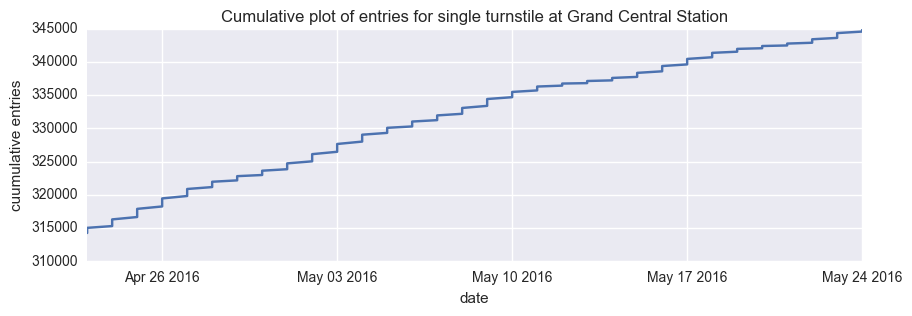

In [131]:
# Plot cumulative entries
mask = ((turnstile_df["C/A"] == "R236") & (turnstile_df["UNIT"] == "R045") & 
        (turnstile_df["SCP"] == "00-00-00") & (turnstile_df["STATION"] == "GRD CNTRL-42 ST"))
plt.figure(figsize=(10,3))
plt.title("Cumulative plot of entries for single turnstile at Grand Central Station")
plt.plot(pd.to_datetime(turnstile_df[mask].DATE), 
         (pd.rolling_window(turnstile_df[mask].ENTRIES, 14)))
plt.xlabel('date')
plt.ylabel('cuumulative entries')

/Users/abhisekswain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=14,axis=0).mean()


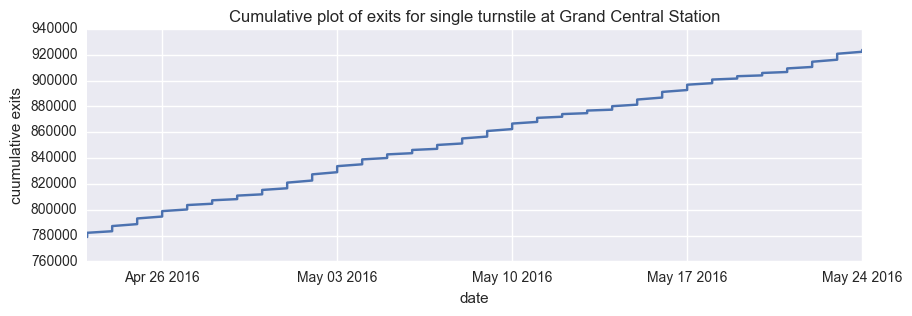

In [132]:
plt.figure(figsize=(10,3))
plt.title("Cumulative plot of exits for single turnstile at Grand Central Station")
plt.plot(pd.to_datetime(turnstile_df[mask].DATE), 
         (pd.rolling_window(turnstile_df[mask].EXITS, 14)))
plt.xlabel('date')
plt.ylabel('cuumulative exits')

Here I will combine everything in each station, and come up with a [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station. The counts are for daily entires and daily exits(not cumulative).

In [133]:
turnstile_df_STATION = turnstile_df.groupby(['STATION','DATE'],as_index = False)["DAILY_ENTRIES", "DAILY_EXITS"].sum()
turnstile_df_STATION.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS
0,1 AV,04/23/2016,19441.0,20950.0
1,1 AV,04/24/2016,15811.0,16685.0
2,1 AV,04/25/2016,20761.0,21359.0
3,1 AV,04/26/2016,21686.0,22917.0
4,1 AV,04/27/2016,22780.0,22866.0


Plotting time series for Grand Central -42 St

In [134]:
turnstile_df_STATION['DATE'] = pd.to_datetime(turnstile_df_STATION['DATE'])

In [135]:
turnstile_df_STATION.sort_values(by='DATE')
turnstile_df_STATION.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS
0,1 AV,2016-04-23,19441.0,20950.0
1,1 AV,2016-04-24,15811.0,16685.0
2,1 AV,2016-04-25,20761.0,21359.0
3,1 AV,2016-04-26,21686.0,22917.0
4,1 AV,2016-04-27,22780.0,22866.0


(25000, 200000)

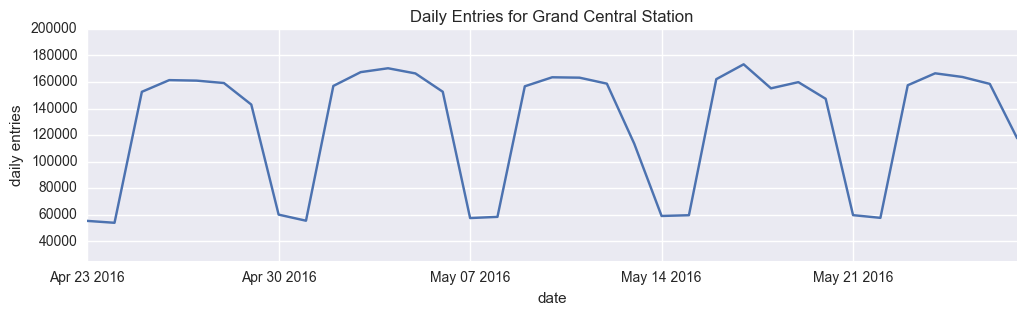

In [136]:
#Plotting daily entires
mask = (turnstile_df_STATION["STATION"] == "GRD CNTRL-42 ST")
plt.figure(figsize=(12,3))
plt.title("Daily Entries for Grand Central Station")
plt.plot((turnstile_df_STATION[mask].DATE), turnstile_df_STATION[mask].DAILY_ENTRIES)
plt.xlabel('date')
plt.ylabel('daily entries')
plt.ylim((25000,200000))

(25000, 200000)

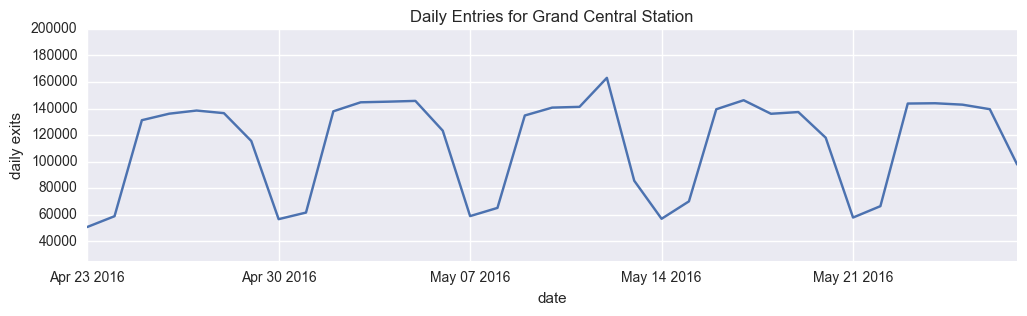

In [137]:
#Plotting daily exits
mask = (turnstile_df_STATION["STATION"] == "GRD CNTRL-42 ST")
plt.figure(figsize=(12,3))
plt.title("Daily Entries for Grand Central Station")
plt.plot((turnstile_df_STATION[mask].DATE), turnstile_df_STATION[mask].DAILY_EXITS)
plt.xlabel('date')
plt.ylabel('daily exits')
plt.ylim((25000,200000))

Let's look at the stations with the highest number of daily entires and exits in the given timeframe.

In [138]:
daily_ent = turnstile_df.groupby(['UNIQUE_STATION'])[['DAILY_ENTRIES']].sum().reset_index().sort_values('DAILY_ENTRIES', ascending = False)
daily_ent1 = daily_ent[0:19]

In [139]:
daily_ent.head()

,UNIQUE_STATION,DAILY_ENTRIES
298,GRD CNTRL-42 ST-4567S,4486280.0
86,34 ST-HERALD SQ-BDFMNQR,3838540.0
420,TIMES SQ-42 ST-1237ACENQRS,2745283.0
89,34 ST-PENN STA-ACE,2484717.0
28,14 ST-UNION SQ-LNQR456,2319366.0


In [140]:
daily_ex = turnstile_df.groupby(['UNIQUE_STATION'])[['DAILY_EXITS']].sum().reset_index().sort_values('DAILY_EXITS', ascending = False)
daily_ex1 = daily_ex[0:19]

In [141]:
daily_ex_ent = turnstile_df.groupby(['UNIQUE_STATION'])[['DAILY_EXITS', 'DAILY_ENTRIES']].sum().reset_index().sort_values('DAILY_EXITS', ascending = False)
daily_ex_ent1 = daily_ex_ent[0:19]

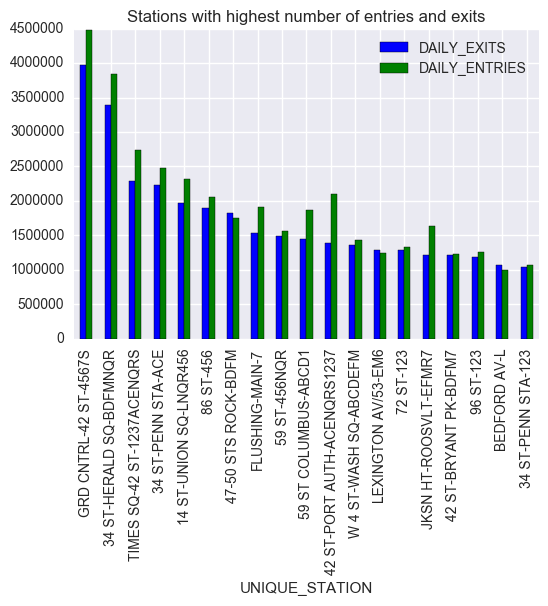

In [142]:
daily_ex_ent1.plot(x = 'UNIQUE_STATION', y = ['DAILY_EXITS','DAILY_ENTRIES'], color = ['blue', 'green'], kind = 'bar')
plt.title("Stations with highest number of entries and exits")

Here I will plot the average number of entries and exits for Grand Central station by day of the week.



In [143]:
mask = (turnstile_df["STATION"] == "GRD CNTRL-42 ST")
weekday_df = turnstile_df[mask].groupby(['STATION','WEEKDAY', 'WEEKDAY_INDEX', 'DATE'])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index().sort_values('DAILY_ENTRIES', ascending = False)
#plt.plot(test1.WEEKDAY_INDEX, test1.DAILY_ENTRIES)

In [144]:
weekday_df1 = weekday_df.groupby(['WEEKDAY', 'WEEKDAY_INDEX'], as_index=False)['DAILY_ENTRIES', 'DAILY_EXITS'].mean()

In [145]:
weekday_df1 = weekday_df1.sort_values(by = 'WEEKDAY_INDEX', ascending = 1)

In [146]:
weekday_df1 

,WEEKDAY,WEEKDAY_INDEX,DAILY_ENTRIES,DAILY_EXITS
1,Monday,0,157198.8,137435.4
5,Tuesday,1,166433.2,142358.8
6,Wednesday,2,162710.8,140788.6
4,Thursday,3,160560.8,144453.6
0,Friday,4,134839.2,108101.8
2,Saturday,5,58416.4,56317.0
3,Sunday,6,57096.8,64511.2


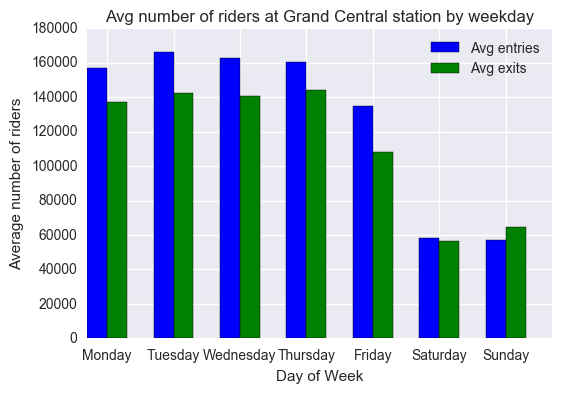

In [147]:
#Chart for Grand Central by day of week
width = 0.3
x = weekday_df1['WEEKDAY_INDEX']
entries = plt.bar(x,weekday_df1['DAILY_ENTRIES'], color='blue',label = 'entries', width = 0.3)
exits = plt.bar(x+width,weekday_df1['DAILY_EXITS'], color='green',label = 'exits',width = 0.3)

plt.xlabel('Day of Week')
plt.ylabel('Average number of riders')
plt.title('Avg number of riders at Grand Central station by weekday')
plt.xticks(x+width,['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend([entries, exits], ['Avg entries', 'Avg exits'])

Lastly, I will plot the average entries and exits over different time periods.

In [148]:
mask = (turnstile_df["STATION"] == "GRD CNTRL-42 ST")
time_df = turnstile_df[mask].groupby(['STATION','TIME'])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index().sort_values('DAILY_ENTRIES', ascending = False)

In [149]:
time_df = time_df.sort_values(by = 'TIME', ascending = 1)

In [150]:
time_df

,STATION,TIME,DAILY_ENTRIES,DAILY_EXITS
0,GRD CNTRL-42 ST,00:00:00,196718.0,247951.0
1,GRD CNTRL-42 ST,08:00:00,461373.0,598295.0
2,GRD CNTRL-42 ST,09:00:00,360494.0,676413.0
3,GRD CNTRL-42 ST,12:00:00,445090.0,364903.0
4,GRD CNTRL-42 ST,13:00:00,535816.0,380786.0
5,GRD CNTRL-42 ST,16:00:00,817099.0,503272.0
6,GRD CNTRL-42 ST,17:00:00,966038.0,350335.0
7,GRD CNTRL-42 ST,20:00:00,273074.0,138146.0
8,GRD CNTRL-42 ST,21:00:00,430578.0,709731.0


In [151]:
time_df = time_df.drop(time_df.index[[2,4,6,8]])

In [152]:
time_df = time_df.reset_index(drop=True)

In [153]:
time_df['TIME'] = time_df['TIME'].astype(str)

In [154]:
time_df

,STATION,TIME,DAILY_ENTRIES,DAILY_EXITS
0,GRD CNTRL-42 ST,00:00:00,196718.0,247951.0
1,GRD CNTRL-42 ST,08:00:00,461373.0,598295.0
2,GRD CNTRL-42 ST,12:00:00,445090.0,364903.0
3,GRD CNTRL-42 ST,16:00:00,817099.0,503272.0
4,GRD CNTRL-42 ST,20:00:00,273074.0,138146.0


In [156]:
times = {'00:00:00': 0, '08:00:00':1, '12:00:00':2, '16:00:00':3, '20:00:00':4}
time_df['HOUR'] = time_df['TIME'].apply(lambda x: times[x])

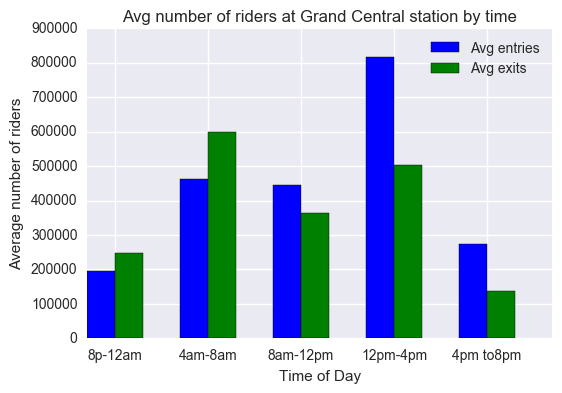

In [157]:
#Chart for Grand Central by day of week
width = 0.3
x = time_df['HOUR']
entries1 = plt.bar(x,time_df['DAILY_ENTRIES'], color='blue',label = 'entries', width = 0.3)
exits1 = plt.bar(x+width,time_df['DAILY_EXITS'], color='green',label = 'exits',width = 0.3)

plt.xlabel('Time of Day')
plt.ylabel('Average number of riders')
plt.title('Avg number of riders at Grand Central station by time')
plt.xticks(x+width,['8p-12am', '4am-8am', '8am-12pm', '12pm-4pm', '4pm to8pm'])
plt.legend([entries1, exits1], ['Avg entries', 'Avg exits'])